Age Cohort Default Rate Analysis
H₀: Default rate is independent of age cohort.
H₁: Default rate depends on age cohort.
Chi-square: Statistic=1898.64, p=0.0000, df=11
Conclusion: Reject H₀; default rate depends on age cohort.

Default Proportions by Age Cohort:
TARGET             0         1
AGE_COHORT                    
0           0.884086  0.115914
1           0.887640  0.112360
2           0.898478  0.101522
3           0.903824  0.096176
4           0.913893  0.086107
5           0.922548  0.077452
6           0.921979  0.078021
7           0.926487  0.073513
8           0.931785  0.068215
9           0.942129  0.057871
10          0.946253  0.053747
11          0.952180  0.047820


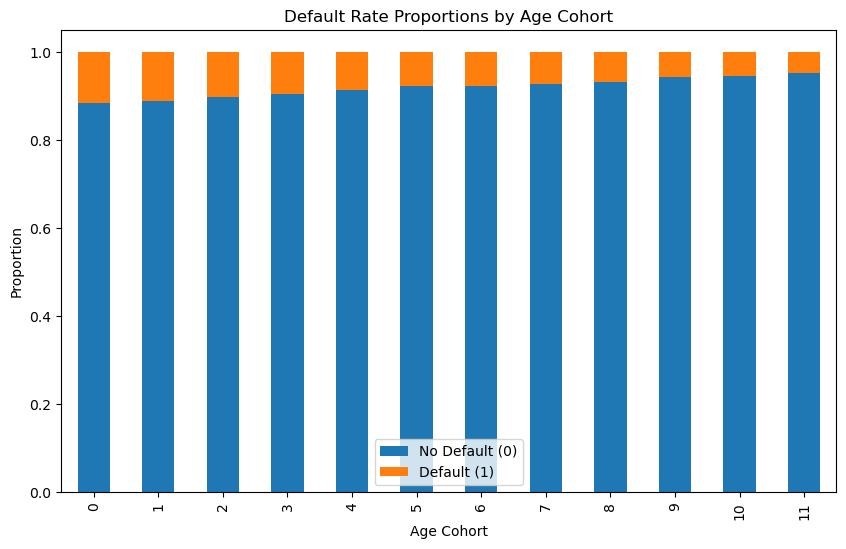

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
df = pd.read_csv('application_train.csv')
df['AGE_YEARS'] = abs(df['DAYS_BIRTH']) / 365
df['AGE_COHORT'] = pd.qcut(df['AGE_YEARS'], 12, labels=False)

# Create contingency table
contingency_table = pd.crosstab(df['AGE_COHORT'], df['TARGET'])

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
alpha = 0.05

print("Age Cohort Default Rate Analysis")
print("H₀: Default rate is independent of age cohort.")
print("H₁: Default rate depends on age cohort.")
print(f"Chi-square: Statistic={chi2:.2f}, p={p:.4f}, df={dof}")
print("Conclusion:", "Reject H₀; default rate depends on age cohort." if p < alpha else "Fail to reject H₀.")

# Proportion analysis
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
print("\nDefault Proportions by Age Cohort:")
print(proportions)

# Visualization
proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Default Rate Proportions by Age Cohort')
plt.xlabel('Age Cohort')
plt.ylabel('Proportion')
plt.legend(['No Default (0)', 'Default (1)'])
plt.show()


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime

# Load and clean data
df = pd.read_csv('application_train.csv')
df['AGE_YEARS'] = abs(df['DAYS_BIRTH']) / 365
df['AGE_COHORT'] = pd.qcut(df['AGE_YEARS'], 12, labels=False)  # 12 equal-sized cohorts
df['TARGET'] = pd.to_numeric(df['TARGET'], errors='coerce')

# === Assumption Checks ===
print("\n=== Logistic Regression Assumption Checks ===")
assumptions_met = True

# 1. Binary Outcome Check
unique_target = df['TARGET'].dropna().unique()
if set(unique_target).issubset({0, 1}):
    print("✅ TARGET is binary.")
else:
    print("❌ TARGET is not binary.")
    assumptions_met = False

# 2. Missing Values Check
missing_X = df['AGE_COHORT'].isnull().sum()
missing_y = df['TARGET'].isnull().sum()
if missing_X == 0 and missing_y == 0:
    print("✅ No missing values in AGE_COHORT or TARGET.")
else:
    print(f"⚠️ Missing values — AGE_COHORT: {missing_X}, TARGET: {missing_y}")
    assumptions_met = False

# 3. One-hot encode AGE_COHORT (drop first as baseline)
X_raw = pd.get_dummies(df['AGE_COHORT'], prefix='COHORT', drop_first=True)
X_raw = sm.add_constant(X_raw)
X_clean = X_raw.apply(pd.to_numeric, errors='coerce')
y_clean = pd.to_numeric(df['TARGET'], errors='coerce')

# 4. Align and drop NaNs
valid_index = X_clean.dropna().index.intersection(y_clean.dropna().index)
X_final = X_clean.loc[valid_index].astype(float)
y_final = y_clean.loc[valid_index].astype(float)

# 5. Multicollinearity Check (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_final.values, i)
                   for i in range(X_final.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)

if vif_data["VIF"].max() < 5:
    print("✅ No severe multicollinearity detected.")
else:
    print("⚠️ High VIF values detected. Consider dropping or combining correlated features.")
    assumptions_met = False

# 6. Sample Size Check
min_class_count = y_final.value_counts().min()
num_predictors = X_final.shape[1] - 1
if min_class_count >= 10 * num_predictors:
    print(f"✅ Sample size is sufficient: {min_class_count} cases in minority class for {num_predictors} predictors.")
else:
    print(f"❌ Sample size may be insufficient: {min_class_count} cases for {num_predictors} predictors.")
    assumptions_met = False

# 7. Linearity of Log-Odds (Placeholder)
print("ℹ️ Linearity of log-odds not tested here. Recommended for continuous predictors using Box-Tidwell.")

# Final decision
if assumptions_met:
    print("\n✅ All key assumptions are met. Proceeding with logistic regression...\n")
else:
    print("\n❌ One or more assumptions not met. Review before proceeding with logistic regression.\n")

# === Fit Logistic Regression ===
model = sm.Logit(y_final, X_final).fit()

# === Detect true baseline cohort ===
all_cohorts = sorted(df['AGE_COHORT'].dropna().unique())
dummy_cohorts = [int(col.replace('COHORT_', '')) for col in X_final.columns if col.startswith('COHORT_')]
baseline_cohort = list(set(all_cohorts) - set(dummy_cohorts))[0]

# === Logistic Regression Summary ===
print("\n=== Logistic Regression for Loan Default Risk ===")
print(model.summary())

# === Business-Friendly Interpretations ===
print("\n=== Business-Friendly Interpretations ===")
intercept = model.params['const']
baseline_odds = np.exp(intercept)
print(f"Baseline (Cohort {baseline_cohort}): log-odds = {intercept:.4f}, odds of default = {baseline_odds:.4f}")

# Model equation
equation_terms = [f"{model.params[col]:+.4f}·{col}" for col in X_final.columns[1:]]
equation = f"log(p / (1 - p)) = {intercept:.4f} " + " ".join(equation_terms)
print(f"\nModel Equation:\n{equation}")

for col in X_final.columns[1:]:
    coef = model.params[col]
    odds_ratio = np.exp(coef)
    direction = "increases" if coef > 0 else "reduces"
    magnitude = (odds_ratio - 1) * 100 if coef > 0 else (1 - odds_ratio) * 100
    cohort = col.replace('COHORT_', '')
    print(f"\nCohort {cohort} vs baseline (Cohort {baseline_cohort}):")
    print(f"- Coefficient: {coef:.4f}")
    print(f"- Odds Ratio: {odds_ratio:.3f}")
    print(f"- Interpretation: Cohort {cohort} {direction} odds of default by {abs(magnitude):.1f}% compared to Cohort {baseline_cohort}.")
    print(f"- Strategy: {'Apply caution' if coef > 0 else 'Prioritize'} Cohort {cohort} applicants in approval and pricing.")

# ============================================
# 1. Default Proportions Dataset
# ============================================
contingency_table = pd.crosstab(df['AGE_COHORT'], df['TARGET'])
default_props_df = (
    contingency_table
    .div(contingency_table.sum(axis=1), axis=0)[1]
    .reset_index()
    .rename(columns={1: 'Default %', 'AGE_COHORT': 'Cohort'})
)
default_props_df['Default %'] = (default_props_df['Default %'] * 100).round(2)

print("\n=== Default Proportions Dataset ===")
print(default_props_df)

# ============================================
# 2. Logistic Regression Summary Dataset
# ============================================
logit_summary_rows = [{
    'Cohort': baseline_cohort,
    'Coefficient': None,
    'Odds Ratio': None,
    'Change vs Baseline': 'Baseline',
    'Baseline Odds of Default': round(baseline_odds, 4)
}]

for col in X_final.columns[1:]:
    cohort = int(col.replace('COHORT_', ''))
    coef = model.params[col]
    odds_ratio = np.exp(coef)
    pct_change = (odds_ratio - 1) * 100
    logit_summary_rows.append({
        'Cohort': cohort,
        'Coefficient': round(coef, 4),
        'Odds Ratio': round(odds_ratio, 3),
        'Change vs Baseline': f"{pct_change:.1f}%",
        'Baseline Odds of Default': None
    })

logit_summary_df = pd.DataFrame(logit_summary_rows)

print("\n=== Logistic Regression Summary Dataset ===")
print(logit_summary_df)

# ============================================
# Optional: Export for Power BI
# ============================================
default_props_df.to_csv("results/default_proportions_age_cohort.csv", index=False)
logit_summary_df.to_csv("results/logistic_regression_summary_age_cohort.csv", index=False)



=== Logistic Regression Assumption Checks ===
✅ TARGET is binary.
✅ No missing values in AGE_COHORT or TARGET.

Variance Inflation Factor (VIF):
      Feature        VIF
0       const  11.997620
1    COHORT_1   1.833066
2    COHORT_2   1.833271
3    COHORT_3   1.833271
4    COHORT_4   1.833300
5    COHORT_5   1.832861
6    COHORT_6   1.833388
7    COHORT_7   1.833212
8    COHORT_8   1.833125
9    COHORT_9   1.833154
10  COHORT_10   1.832978
11  COHORT_11   1.832891
⚠️ High VIF values detected. Consider dropping or combining correlated features.
✅ Sample size is sufficient: 24825 cases in minority class for 11 predictors.
ℹ️ Linearity of log-odds not tested here. Recommended for continuous predictors using Box-Tidwell.

❌ One or more assumptions not met. Review before proceeding with logistic regression.

Optimization terminated successfully.
         Current function value: 0.277434
         Iterations 7

=== Logistic Regression for Loan Default Risk ===
                           Log

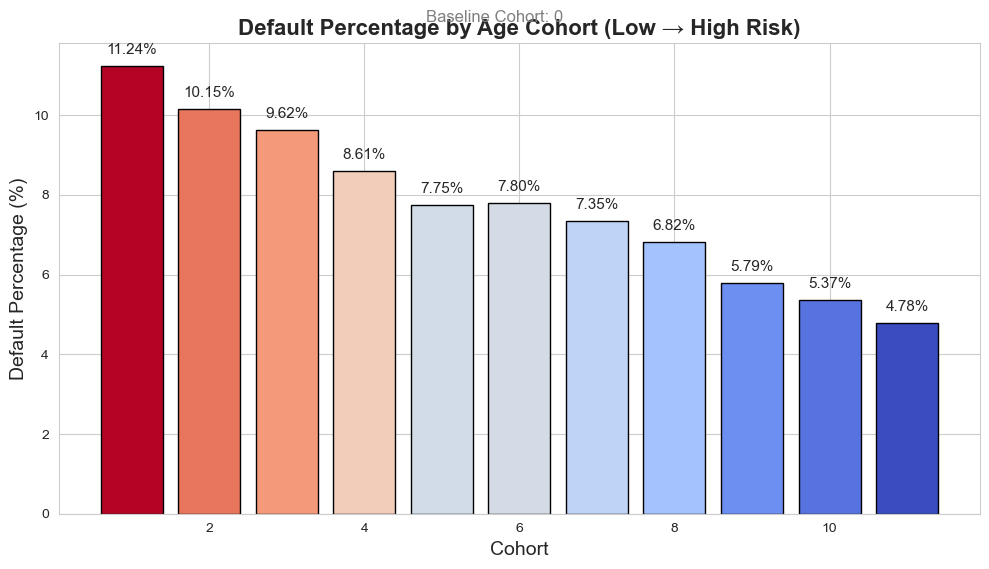

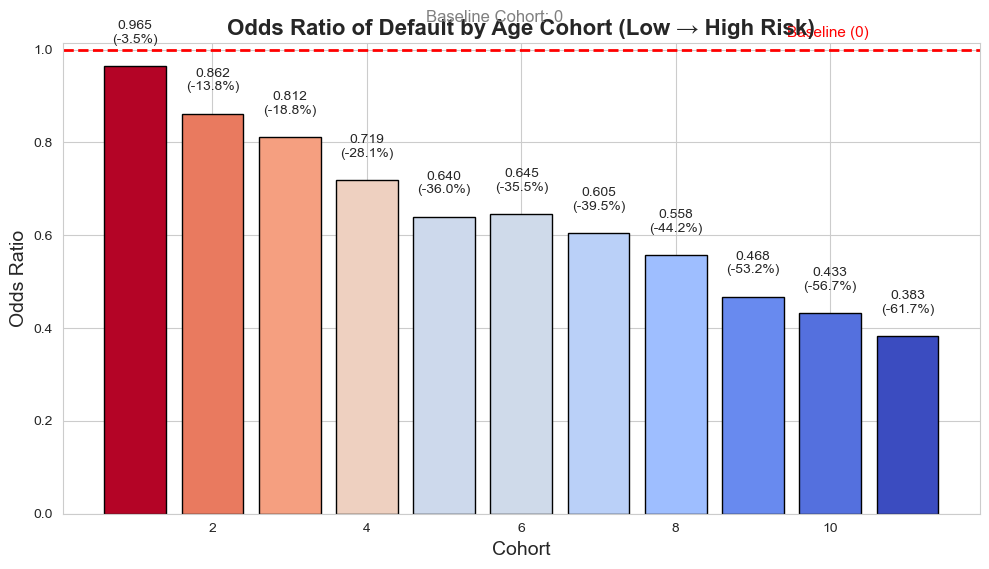

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import os

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

# ==============================
# 1. Determine common order by Odds Ratio
# ==============================
odds_sorted = (
    logit_summary_df
    .dropna(subset=['Odds Ratio'])
    .sort_values('Odds Ratio', ascending=True)
)
cohort_order = odds_sorted['Cohort'].tolist()

# Reorder default_props_df to match
default_props_ordered = default_props_df.copy()
default_props_ordered = default_props_ordered.set_index('Cohort').loc[cohort_order].reset_index()

odds_ratio_ordered = odds_sorted.copy()

# ==============================
# 2. Default Percentage Chart
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_def = Normalize(vmin=default_props_ordered['Default %'].min(),
                     vmax=default_props_ordered['Default %'].max())
colors_def = cm.coolwarm(norm_def(default_props_ordered['Default %']))

bars = plt.bar(default_props_ordered['Cohort'],
               default_props_ordered['Default %'],
               color=colors_def, edgecolor='black')

# Highlight baseline
for bar, label in zip(bars, default_props_ordered['Cohort']):
    if label == baseline_cohort:
        bar.set_linewidth(2.5)
        bar.set_edgecolor('black')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 "Baseline", ha='center', fontsize=10, fontweight='bold', color='black')

plt.title("Default Percentage by Age Cohort (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Cohort: {baseline_cohort}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Cohort", fontsize=14)
plt.ylabel("Default Percentage (%)", fontsize=14)
plt.xticks(rotation=0)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3,
             f"{height:.2f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("results/age_cohort_default_percentage_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()

# ==============================
# 3. Odds Ratio Chart
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_or = Normalize(vmin=odds_ratio_ordered['Odds Ratio'].min(),
                    vmax=odds_ratio_ordered['Odds Ratio'].max())
colors_or = cm.coolwarm(norm_or(odds_ratio_ordered['Odds Ratio']))

bars = plt.bar(odds_ratio_ordered['Cohort'],
               odds_ratio_ordered['Odds Ratio'],
               color=colors_or, edgecolor='black')

# Baseline line + label
plt.axhline(1, color='red', linestyle='--', linewidth=2)
plt.text(len(odds_ratio_ordered)-0.5, 1.02,
         f"Baseline ({baseline_cohort})",
         color='red', fontsize=11, va='bottom', ha='right')

plt.title("Odds Ratio of Default by Age Cohort (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Cohort: {baseline_cohort}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Cohort", fontsize=14)
plt.ylabel("Odds Ratio", fontsize=14)
plt.xticks(rotation=0)

# Annotate bars
for bar, change in zip(bars, odds_ratio_ordered['Change vs Baseline']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05,
             f"{height:.3f}\n({change})", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("results/age_cohort_odds_ratio_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()



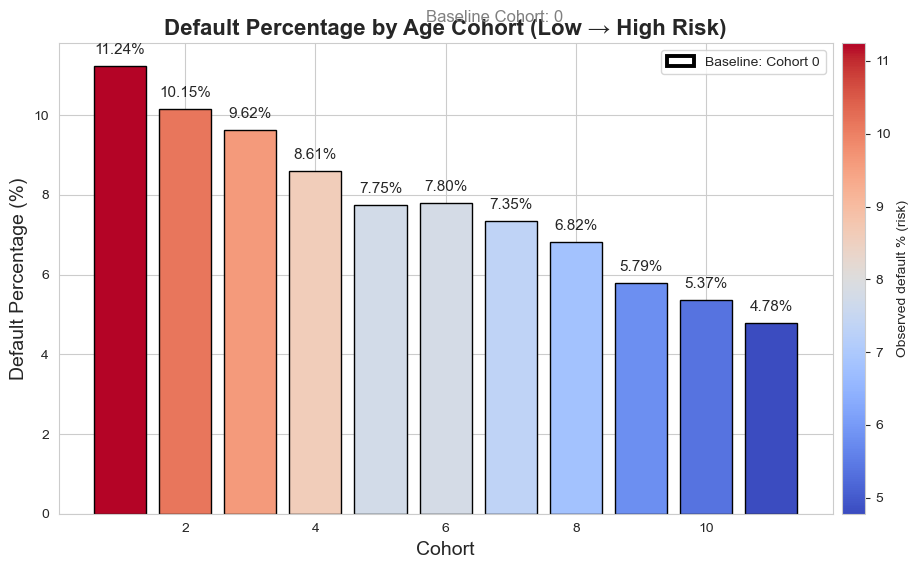

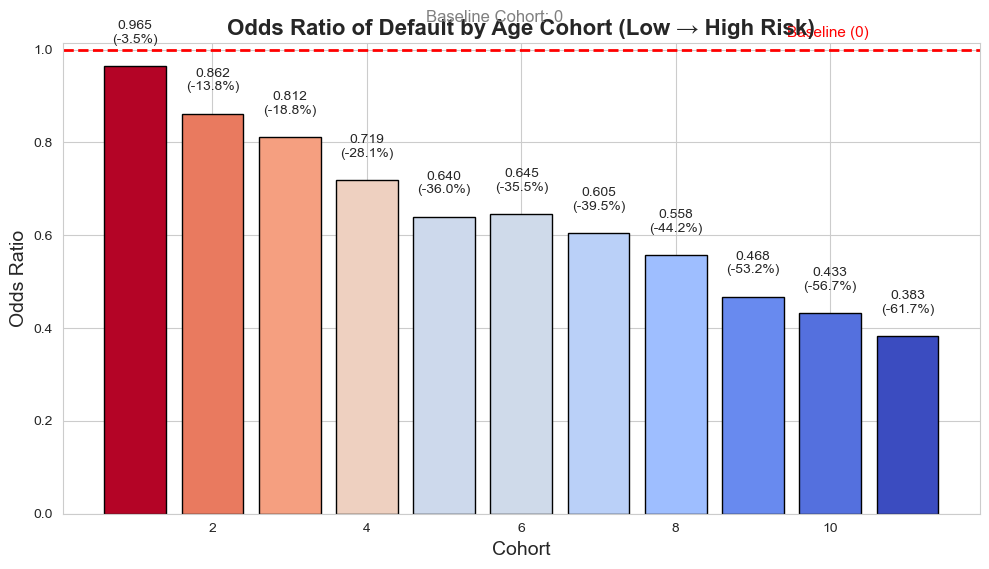

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import Normalize
import os

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

# ==============================
# 1. Determine common order by Odds Ratio
# ==============================
odds_sorted = (
    logit_summary_df
    .dropna(subset=['Odds Ratio'])
    .sort_values('Odds Ratio', ascending=True)
)
cohort_order = odds_sorted['Cohort'].tolist()

# Reorder default_props_df to match
default_props_ordered = default_props_df.copy()
default_props_ordered = default_props_ordered.set_index('Cohort').loc[cohort_order].reset_index()

odds_ratio_ordered = odds_sorted.copy()

# ==============================
# 2. Default Percentage Chart (with explicit baseline annotation)
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_def = Normalize(vmin=default_props_ordered['Default %'].min(),
                     vmax=default_props_ordered['Default %'].max())
colors_def = cm.coolwarm(norm_def(default_props_ordered['Default %']))

bars = plt.bar(default_props_ordered['Cohort'],
               default_props_ordered['Default %'],
               color=colors_def, edgecolor='black')

# Titles & labels
plt.title("Default Percentage by Age Cohort (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Cohort: {baseline_cohort}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Cohort", fontsize=14)
plt.ylabel("Default Percentage (%)", fontsize=14)
plt.xticks(rotation=0)

# Annotate each bar with the value
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.3, f"{h:.2f}%", ha='center', fontsize=11)

# Highlight baseline bar: thicker border + explicit arrow annotation
cohort_list = list(default_props_ordered['Cohort'])
if baseline_cohort in cohort_list:
    idx = cohort_list.index(baseline_cohort)
    base_bar = bars[idx]
    base_bar.set_linewidth(2.8)
    base_bar.set_edgecolor('black')

    # Arrow annotation pointing to the baseline bar
    plt.annotate(
        f"Baseline: Cohort {baseline_cohort}",
        xy=(base_bar.get_x() + base_bar.get_width()/2, base_bar.get_height()),
        xytext=(base_bar.get_x() + base_bar.get_width()/2,
                base_bar.get_height() + (default_props_ordered['Default %'].max() * 0.15)),
        ha='center',
        arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
        fontsize=11, fontweight='bold', color='black'
    )

# Optional colorbar to emphasize risk mapping
sm = cm.ScalarMappable(cmap=cm.coolwarm, norm=norm_def)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)
cbar.set_label("Observed default % (risk)")

# Legend entry for baseline border
baseline_patch = mpatches.Patch(facecolor='none', edgecolor='black', linewidth=2.8,
                                label=f"Baseline: Cohort {baseline_cohort}")
plt.legend(handles=[baseline_patch], loc='upper right', frameon=True)

plt.tight_layout()
plt.savefig("results/age_cohort_default_percentage_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()

# ==============================
# 3. Odds Ratio Chart
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_or = Normalize(vmin=odds_ratio_ordered['Odds Ratio'].min(),
                    vmax=odds_ratio_ordered['Odds Ratio'].max())
colors_or = cm.coolwarm(norm_or(odds_ratio_ordered['Odds Ratio']))

bars = plt.bar(odds_ratio_ordered['Cohort'],
               odds_ratio_ordered['Odds Ratio'],
               color=colors_or, edgecolor='black')

# Baseline line + label
plt.axhline(1, color='red', linestyle='--', linewidth=2)
plt.text(len(odds_ratio_ordered)-0.5, 1.02,
         f"Baseline ({baseline_cohort})",
         color='red', fontsize=11, va='bottom', ha='right')

plt.title("Odds Ratio of Default by Age Cohort (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Cohort: {baseline_cohort}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Cohort", fontsize=14)
plt.ylabel("Odds Ratio", fontsize=14)
plt.xticks(rotation=0)

# Annotate bars with odds ratio and % change
for bar, change in zip(bars, odds_ratio_ordered['Change vs Baseline']):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.05,
             f"{h:.3f}\n({change})", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("results/age_cohort_odds_ratio_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()


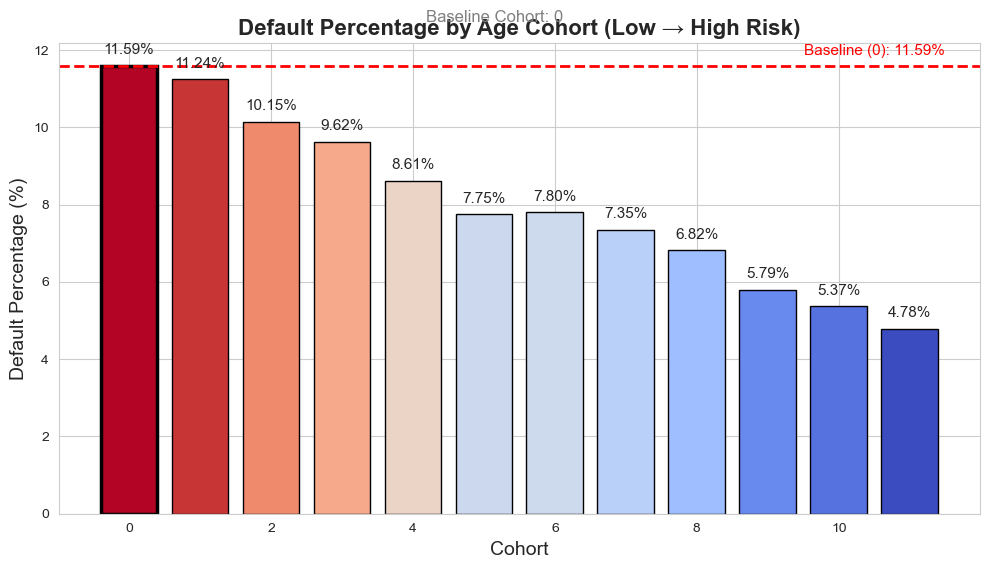

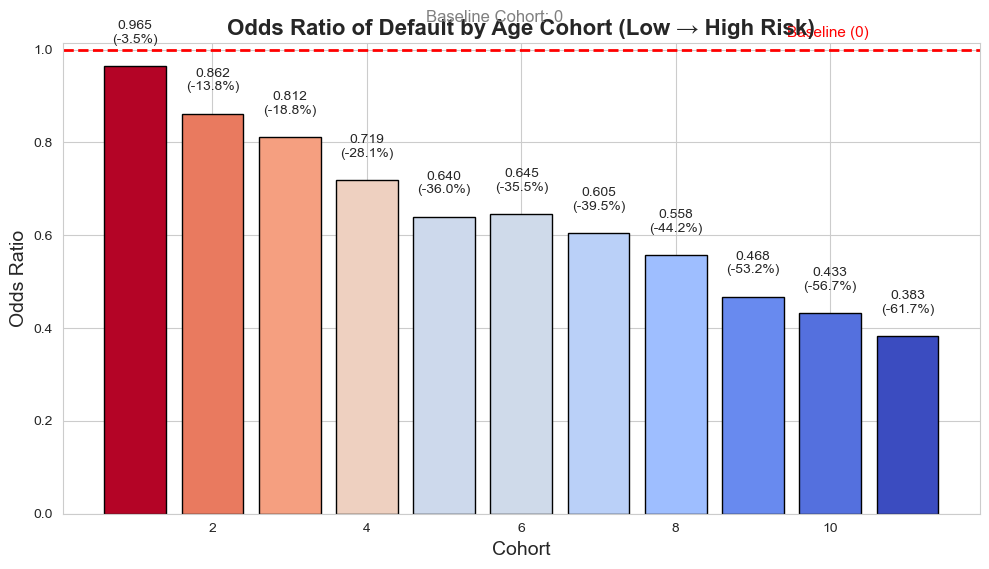

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
import os

# Ensure output folder exists
os.makedirs("results", exist_ok=True)

# ==============================
# 1. Determine common order by Odds Ratio (low → high risk)
# ==============================
odds_sorted = (
    logit_summary_df
    .dropna(subset=['Odds Ratio'])
    .sort_values('Odds Ratio', ascending=True)
)
cohort_order = odds_sorted['Cohort'].tolist()

# Ensure baseline is in the order list
if baseline_cohort not in cohort_order:
    cohort_order = [baseline_cohort] + cohort_order

# Reorder default_props_df to match
default_props_ordered = default_props_df.copy()
default_props_ordered = default_props_ordered.set_index('Cohort').loc[cohort_order].reset_index()

odds_ratio_ordered = odds_sorted.copy()

# ==============================
# 2. Default Percentage Chart (with baseline dashed line)
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_def = Normalize(vmin=default_props_ordered['Default %'].min(),
                     vmax=default_props_ordered['Default %'].max())
colors_def = cm.coolwarm(norm_def(default_props_ordered['Default %']))

bars = plt.bar(default_props_ordered['Cohort'],
               default_props_ordered['Default %'],
               color=colors_def, edgecolor='black')

# Safely get baseline default percentage
mask = default_props_ordered['Cohort'] == baseline_cohort
if mask.any():
    baseline_value = default_props_ordered.loc[mask, 'Default %'].iloc[0]
    # Draw baseline dashed line + label
    plt.axhline(baseline_value, color='red', linestyle='--', linewidth=2)
    plt.text(len(default_props_ordered)-0.5, baseline_value + 0.2,
             f"Baseline ({baseline_cohort}): {baseline_value:.2f}%",
             color='red', fontsize=11, va='bottom', ha='right')

# Highlight baseline bar
for bar, label in zip(bars, default_props_ordered['Cohort']):
    if label == baseline_cohort:
        bar.set_linewidth(2.5)
        bar.set_edgecolor('black')

# Titles & labels
plt.title("Default Percentage by Age Cohort (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Cohort: {baseline_cohort}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Cohort", fontsize=14)
plt.ylabel("Default Percentage (%)", fontsize=14)
plt.xticks(rotation=0)

# Annotate bars
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.3, f"{h:.2f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("results/age_cohort_default_percentage_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()

# ==============================
# 3. Odds Ratio Chart (with baseline dashed line at 1.0)
# ==============================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

norm_or = Normalize(vmin=odds_ratio_ordered['Odds Ratio'].min(),
                    vmax=odds_ratio_ordered['Odds Ratio'].max())
colors_or = cm.coolwarm(norm_or(odds_ratio_ordered['Odds Ratio']))

bars = plt.bar(odds_ratio_ordered['Cohort'],
               odds_ratio_ordered['Odds Ratio'],
               color=colors_or, edgecolor='black')

# Baseline line + label
plt.axhline(1, color='red', linestyle='--', linewidth=2)
plt.text(len(odds_ratio_ordered)-0.5, 1.02,
         f"Baseline ({baseline_cohort})",
         color='red', fontsize=11, va='bottom', ha='right')

plt.title("Odds Ratio of Default by Age Cohort (Low → High Risk)", fontsize=16, weight='bold')
plt.suptitle(f"Baseline Cohort: {baseline_cohort}", fontsize=12, color='gray', y=0.94)
plt.xlabel("Cohort", fontsize=14)
plt.ylabel("Odds Ratio", fontsize=14)
plt.xticks(rotation=0)

# Annotate bars with odds ratio and % change
for bar, change in zip(bars, odds_ratio_ordered['Change vs Baseline']):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.05,
             f"{h:.3f}\n({change})", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("results/age_cohort_odds_ratio_coolwarm_ordered.png", dpi=300)
plt.show()
plt.close()
